# Group Project 2

### Alex Hausser, Devin Hayes, Galen Sieck, Minh Nguyen, Vivek Nair

In this project, you will implement a numerical method to study the wave equation. The wave equation
is one of the most important partial differential equations in engineering because it is used to model many
relevant systems, such as seismic waves, deformation of elastic rods (and related elastic media), motion
of strings, and dynamics of acoustic waves (i.e., sound)! In one spatial dimension (1D), the simplest form
that the wave equation takes is,

$$
\frac{\partial^2{u}}{\partial{t}^2} = c^2 \frac{\partial^2{u}}{\partial{x}^2}
$$

where c is a constant referred to as the wave speed. There are many variants to eq. (1) that can arise from
having a wave speed c that depends on space, presence of a prescribed forcing function, etc. Different
initial and boundary conditions, which depend on the problem being chosen, will also change the solution.
For this project, please do the following:

1) Define a system of interest to your group that can be meaningfully modelled using a variant of the wave equation and choose parameters for that system, as needed for eq. (1). You are encouraged to use curiosity when defining this system, but your final choice for the form of the wave equation and associated parameters should be informed by some research into the problem. I suggest you stick to one of the following topics: (i) deformation of elastic rods, (ii) acoustics, or (iii) seismic waves, since these topics lead to interesting models using a 1D wave equation. There are other topics (e.g., the motion of a plucked string) that can be modeled by the wave equation, but these require at least two spatial dimensions which is beyond the scope of this class.

2) Select and implement an appropriate numerical method/methods to simulate your system. You have freedom here, for example, you can choose a finite different method, finite element method, or something not covered in class. Even if you use a finite difference or finite element method, you can choose one not covered in class. You must write your solver from scratch, that is, you may not use an existing Python method like scipy.integrate.rk45.

3) Write a report summarizing your problem, numerical method, results, and conclusions. Some expectations for the report are below:

(a) Your report should be written in AIAA format (section headings are up to you). Word and LaTeX templates can be found here: https://www.aiaa.org/events-learning/events/Technical- Presenter-Resources.

(b) There is maximum page limit of 6 pages, excluding references and an appendix (the appendix has a maximum page limit of 4 pages). You can use an appendix to include information that is helpful but not necessary to your main story.

(c) Your report should have a professional tone appropriate for a technical document.

(d) Your system should be clearly defined. That is, you should clearly specify which variant of the wave equation you are using (e.g., do you need a spatially varying wave speed) and what associated parameters you choose. You should justify these choices by including references
when possible.

(e) The numerical method/methods you use should be clearly defined and justified (using arguments of accuracy and stability from class). You should NOT re-derive any results that are commonly known, but you SHOULD specify any details that are unique to your implementation or were not covered in class (e.g., if you choose a method not covered in class, you should define the key equations).

(f) Your results should demonstrate that you have correctly implemented your method/methods using a convergence test (i.e., comparing the scaling of your error to the expected scaling for various choices of Δx and Δt).

(g) Your results should include analysis of your system dynamics under various meaningfully selected parameter settings.

(h) Any plots should be clear and concise in showing the desired information. Notice that for N ≥ 3, you will need to think about meaningful ways to visualize results. A crucial piece of being an engineer is conveying technical information in a concise, visually appealing manner. 

Since this is a project, you are expected to go well beyond what is typical of a homework submission and take ownership of your work on this project. Going “beyond what is typical” can mean different things to different teams. For some, that may mean exploring new numerical methods we did not consider in class. For others, it may mean taking a method/methods used in class and extensively exploring your system. Either approach is great; just be sure to work hard and have fun! 

You will work in a small assigned groups. You may split up the work as you see fit. For example, everyone can equally contribute to every part of the project or you can provide team leads for various parts (like defining the problem statement, picking and implementing the method, writing the report, etc.) Whatever approach you take, make sure that every group member contributes meaningfully to the project. You will all fill out a confidential survey after submitting your work, and if there is a consensus that one or more of the team members was not a significant contributor, there will be a substantial grade based penalty depending on the severity of the infraction.

In [25]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve

**G Functions**

In [2]:
# Sin(pi*x) Forcing Function
def g_function(x_points_array, t):
    top_half = np.zeros(n-1)
    bottom_half = np.sin(np.pi*x_points_array)
    ans = np.concatenate((top_half, bottom_half))
    return ans

In [3]:
# 0 forcing function
def g_function0(x_points_array, t):
    return np.zeros(2*n-2)

**Trapezoidal Method**

In [26]:
# Knowns
T = 5
a = 0
b = 5
n = 1000
dt = 0.01

# Sine Forcing Function

def trapIVP(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coeffcient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi*x_interp_cut)
#     u0s = np.zeros(n-1)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        g_tk = g_function(x_interp_cut, times[i])
        g_tkp1 = g_function(x_interp_cut, times[i] + dt)
        RHS = U[i] + (dt/2) * (A @ U[i] + g_tk + g_tkp1)
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:999]
    
    return U, times, x_interp_cut

In [27]:
# Zero Forcing Function

def trapIVP0(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coeffcient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        g_tk = g_function0(x_interp_cut, times[i])
        g_tkp1 = g_function0(x_interp_cut, times[i] + dt)
        RHS = U[i] + (dt/2) * (A @ U[i] + g_tk + g_tkp1)
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:999]
    
    return U, times, x_interp_cut

**Forward Euler**

In [28]:
def FEIVP(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coeffcient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        g_tk = g_function(x_interp_cut, times[i])
        RHS = U[i] + (dt) * (A @ U[i] + g_tk)
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:999]
    
    return U, times, x_interp_cut

**Data**

In [33]:
E = 70
rho = 2700

# All Displacements at each time step
U1, times1, x_int = trapIVP(E, rho, dt, n)
U2 = FEIVP(E, rho, dt, n)[0]

# Trap Displacements at different times
U1_t0 = U1[0]
U1_t5 = U1[50]

# FE Displacements at different times
U2_t0 = U2[0]
U2_t5 = U2[50]

C:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


**Graphs**

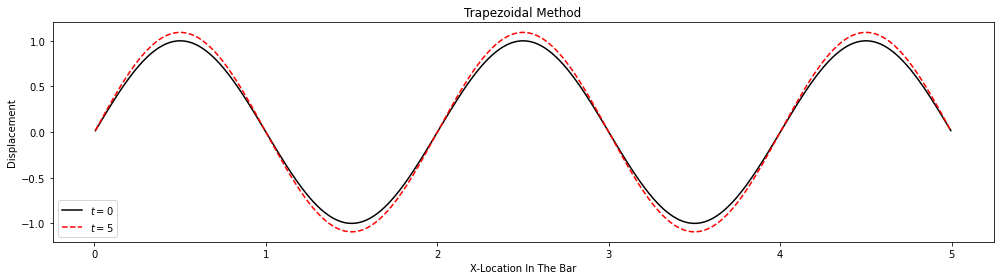

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.plot(x_int, U1_t0, 'k', label=r'$t=0$')
ax1.plot(x_int, U1_t5, 'r--', label=r'$t=5$')
ax1.set_xlabel('X-Location In The Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_title('Trapezoidal Method')
ax1.legend(loc='lower left');

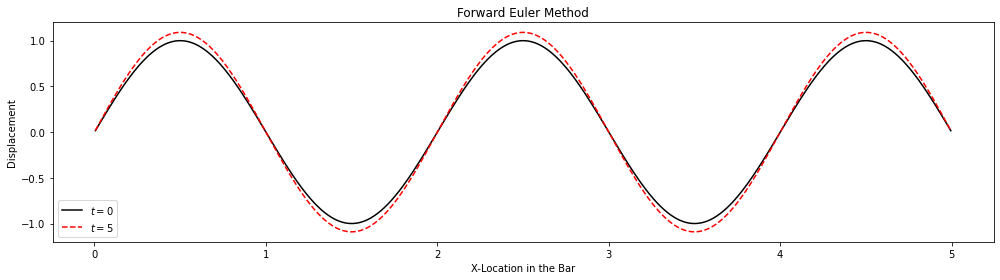

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.plot(x_int, U2_t0, 'k', label=r'$t=0$')
ax1.plot(x_int, U2_t5, 'r--', label=r'$t=5$')
ax1.set_xlabel('X-Location in the Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_title('Forward Euler Method')
ax1.legend(loc='lower left');

**A Matrix Scratch**

In [11]:
ind = np.arange(0, 2*n-2, 1)
ones = np.ones(n-1)
dx = (b-a) / n
rho = 2700
E = 70
coef = rho*dx**2/E

ind_top_half_rows = ind[0:999]
ind_top_half_cols = ind[999:]
ind_bot_half_rows = ind[999:]
ind_bot_half_cols = ind[0:999]

# Add -2 diagonal
neg2s = -2*ones
A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

# Add top 1 diagonal
A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

# Add bottom 1 diagonal
A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

# Add top diagonal
coefs = coef*ones
A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

A = A*E/(rho*dx**2)

A.toarray()[998]

array([0., 0., 0., ..., 0., 0., 1.])